In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [16]:
# import dataset
iris = sns.load_dataset('iris')

# convert pandas to tensor
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float)

# label encoding
labels = torch.zeros(data.shape[0],dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [17]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

batchSize = 16
train_loader = DataLoader(train_data,shuffle=True,batch_size=batchSize)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [18]:
class Net(nn.Module):
     def __init__(self,dropoutRate):
        super().__init__()
        
        ### layers
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)
        
        # parameters
        self.dr = dropoutRate
         
     def forward(self, x):
         
         x = F.relu(self.input(x))
         
         # dropout after input layer , self.training means is set true when model is in train mode
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = F.relu( self.hidden(x) )
         
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = self.output(x)
         
         return x

In [19]:
# function to create model
def createNet(dropoutRate):
    
    ANNQC = Net(dropoutRate)
    
    lossFn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.005)
    
    return ANNQC, lossFn, optimizer

In [20]:
# train the model
num_epochs = 500

def trainNet(ANNQC, lossFn,optimizer):
    
    trainAcc = []
    testAcc = []
    
    
    
    for epochI in range(num_epochs):
        # switch training mode on
        ANNQC.train()
            
        batchAcc = []
        for X,y in train_loader:
            
            yHat = ANNQC(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item())
        
        trainAcc.append( np.mean(batchAcc))
        ANNQC.eval()
        X,y = next(iter(test_loader))
        predLabels = torch.argmax(ANNQC(X),dim=1)
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
    return trainAcc,testAcc

In [21]:
dropoutRate = .0

ANNQC, lossFn, optimizer = createNet(dropoutRate)

trainAcc,testAcc = trainNet(ANNQC,lossFn,optimizer)

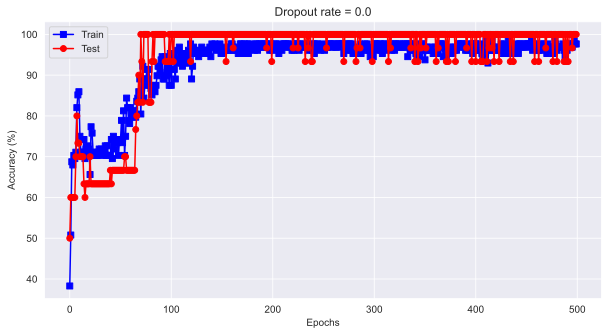

In [22]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train","Test"])
plt.title("Dropout rate = {}".format(dropoutRate))

plt.show()

In [23]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for dI in range(len(dropoutRates)):
    
    ANNQC, lossFn, optimizer = createNet(dropoutRates[dI])
    trainAcc,testAcc = trainNet(ANNQC,lossFn,optimizer)
    
    results[dI,0] = np.mean(trainAcc[-50:])
    results[dI,1] = np.mean(testAcc[-50:])
    

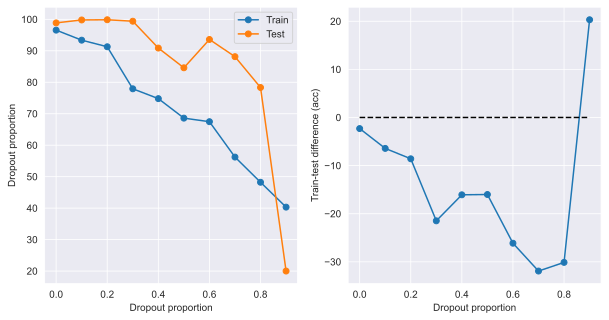

In [24]:
fig ,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Dropout proportion")
ax[0].legend(["Train","Test"])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc)")

plt.show()